## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, 
    ELU, LSTM, Dense, 
    Dropout, TimeDistributed, 
    Conv1D, 
    MaxPooling1D,
    Flatten, Bidirectional, 
    Flatten, 
    RepeatVector)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pickle

from utils import *

import quantstats as qs

import warnings
warnings.filterwarnings("ignore")

from matplotlib.ticker import FuncFormatter

2024-02-22 00:51:08.239586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Loading

In [2]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')

stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

index_returns = pd.read_pickle('data/index_returns.pkl')

In [3]:
tukey.head()

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2013-01-07,153.939608,15.863052,70.854575,44.436658,19.238627,1.380126,72.813778,127.405070,3.231326,13.850115,...,105.634999,7.310501,49.852665,61.648194,7.369072,18.959361,12.610719,29.582595,67.114440,8.771007
2013-01-08,152.295129,15.864724,70.827743,44.922120,19.152028,1.390526,73.053974,126.747672,3.202159,13.846611,...,104.938642,7.356010,49.264694,61.258046,7.436251,18.885706,12.580650,30.070623,66.745362,8.812163
2013-01-09,150.639015,15.827395,71.009542,45.323106,19.125098,1.405432,73.282788,126.031903,3.195986,13.749587,...,104.897190,7.447657,48.849551,61.011026,7.526238,18.937751,12.583433,30.564229,66.302363,8.861539
2013-01-10,149.452580,15.727265,70.822367,45.607353,19.161744,1.428110,73.181097,124.892381,3.190310,13.623088,...,104.390636,7.557309,48.616030,60.806893,7.616594,18.997714,12.550908,31.038729,65.602069,8.973196
2013-01-11,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104


## Data Preparation

In [4]:
# create test set of returns for the benchmark (SX5E index)
test_index_ret = index_returns.loc['2017-01-02':]

# Calculate index final performance
benchmark_perf = ((1 + test_index_ret).cumprod() - 1) * 100

In [5]:
LOOK_BACK = 50
n_features = len(tukey.columns)
FORECAST_RANGE = 21

In [6]:
starting_date_test = tukey.loc[:'2016-12-30'].index[-(LOOK_BACK)]

In [7]:
train_price, test_price = tukey.loc[:'2016-12-30'], tukey.loc[starting_date_test:]

In [8]:
train_price.shape, test_price.shape

((1015, 41), (304, 41))

In [9]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [10]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print('(Samples, time steps, features)')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(Samples, time steps, features)
(945, 50, 41)
(945, 21, 41)
(234, 50, 41)
(234, 21, 41)


## Useful Functions

In [11]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse


## Monthly Rebalance strategy

In [27]:
def monthly_rebalance_strategy(model, X_test, y_test, stocks_returns, stocks_names, LOOK_BACK=LOOK_BACK, verbose=1):

    """
    IMPORTANT: insert as input stock_returns only from 2017-01-02

    """

    top5_returns = pd.Series()
    top7_returns = pd.Series()
    top10_returns = pd.Series()


    for i in np.arange(0, 252, 21):


        period  = stocks_returns.iloc[np.arange(i, (i + 21), 1)].index

        ### STORE THE X_i
        X_i = X_test[i].reshape(1, LOOK_BACK, 41)
        
        ### PREDICT AND REFIT THE MODEL
        yhat = model.predict(X_i, verbose=verbose)

        ### MANIPULATE PREDICTION
        yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
        yhat_inverse_df = pd.DataFrame(yhat_inverse, index=period, columns=stocks_names)

        ### CALCULATE RANKING AND PORTFOLIOS PERFORMANCE
        ranking = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
        performance, returns = calc_portfolios(ranking, stocks_returns.loc[period])
        
        top5_returns = pd.concat([top5_returns, returns['Top 5 returns']], axis=0)
        top7_returns = pd.concat([top7_returns, returns['Top 7 returns']], axis=0)
        top10_returns = pd.concat([top10_returns, returns['Top 10 returns']], axis=0)

        ### REFIT MODEL BEFORE THE FOLLOWING ITERATION

        if i < (252-21):
            refit_X = X_test[(i+21)].reshape(1, LOOK_BACK, 41)
            model.fit(refit_X, y_test[i].reshape(1, 21, 41), epochs=10, batch_size=32, verbose=0)
    
    
    return top5_returns, top7_returns, top10_returns


## Simple LSTM (Enc-Dec)

In [25]:
model_enc_dec = Sequential(name='LSTM')
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))   # for multi-step forecasting if n>1
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(41)))

In [285]:
model_enc_dec.compile(optimizer='adam', loss='mse')

In [286]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
30/30 [==============================] - 2s 23ms/step - loss: 0.1092
Epoch 2/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0270
Epoch 3/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0152
Epoch 4/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0108
Epoch 5/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0093
Epoch 6/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0086
Epoch 7/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0073
Epoch 8/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0070
Epoch 9/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0066
Epoch 10/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0058
Epoch 11/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0054
Epoch 12/50
30/30 [==============================] - 1s 24ms/step - loss: 0.0052
Epoch 13/50
30/30 [==================

In [287]:
top5_returns, top7_returns, top10_returns = monthly_rebalance_strategy(model_enc_dec, X_test, y_test, stocks_returns.loc['2017-01-02':], tukey.columns, verbose=0)

In [288]:
top5_cumret, top7_cumret, top10_cumret = ((1 + top5_returns).cumprod() - 1)*100, ((1 + top7_returns).cumprod() - 1)*100, ((1 + top10_returns).cumprod() - 1)*100

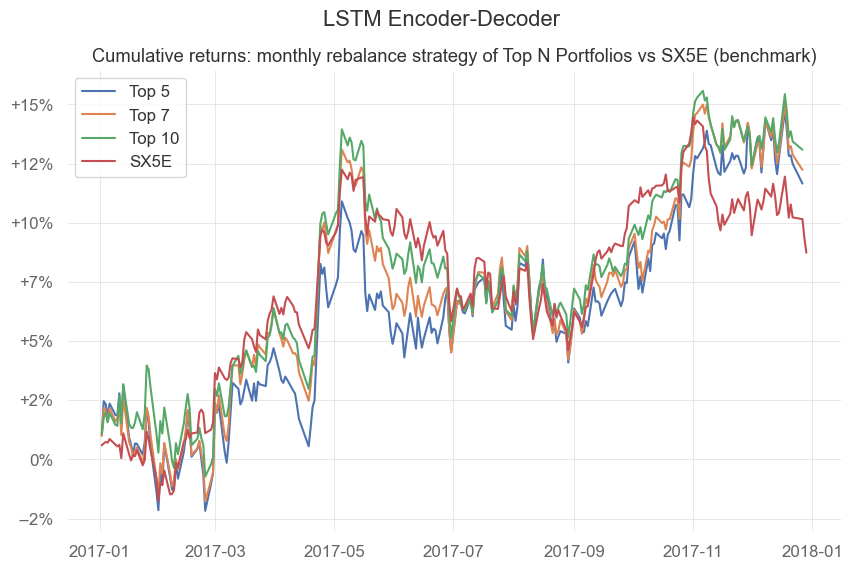

In [290]:
plt.plot(top5_cumret, label = 'Top 5')
plt.plot(top7_cumret, label = 'Top 7')
plt.plot(top10_cumret, label = 'Top 10')
plt.plot(benchmark_perf, label = 'SX5E')

ax = plt.gca()

# Define the percentage formatter function
def percentage_formatter(x, pos):
    if x == 0:
        return f'{int(x)}%'
    elif x > 0:
        return f'+{int(x)}%'
    else:
        return f'-{int(x)}%'
   
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('Cumulative returns: monthly rebalance strategy of Top N Portfolios vs SX5E (benchmark)')
plt.suptitle('LSTM')

plt.legend();

## BILSTM

In [291]:
bilstm = Sequential(name='BiLSTM')
bilstm.add(Bidirectional(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features))))
bilstm.add(RepeatVector(FORECAST_RANGE))
bilstm.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
bilstm.add(TimeDistributed(Dense(n_features)))

In [292]:
bilstm.compile(optimizer='adam', loss='mse')

In [293]:
history = bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
30/30 [==============================] - 4s 36ms/step - loss: 0.0895
Epoch 2/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0187
Epoch 3/50
30/30 [==============================] - 1s 37ms/step - loss: 0.0118
Epoch 4/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0087
Epoch 5/50
30/30 [==============================] - 2s 52ms/step - loss: 0.0063
Epoch 6/50
30/30 [==============================] - 2s 61ms/step - loss: 0.0053
Epoch 7/50
30/30 [==============================] - 2s 54ms/step - loss: 0.0047
Epoch 8/50
30/30 [==============================] - 2s 53ms/step - loss: 0.0043
Epoch 9/50
30/30 [==============================] - 2s 61ms/step - loss: 0.0039
Epoch 10/50
30/30 [==============================] - 2s 52ms/step - loss: 0.0041
Epoch 11/50
30/30 [==============================] - 2s 58ms/step - loss: 0.0039
Epoch 12/50
30/30 [==============================] - 2s 52ms/step - loss: 0.0032
Epoch 13/50
30/30 [==================

In [294]:
top5_returns, top7_returns, top10_returns = monthly_rebalance_strategy(bilstm, X_test, y_test, stocks_returns.loc['2017-01-02':], tukey.columns, verbose=0)

In [295]:
top5_cumret, top7_cumret, top10_cumret = ((1 + top5_returns).cumprod() - 1)*100, ((1 + top7_returns).cumprod() - 1)*100, ((1 + top10_returns).cumprod() - 1)*100

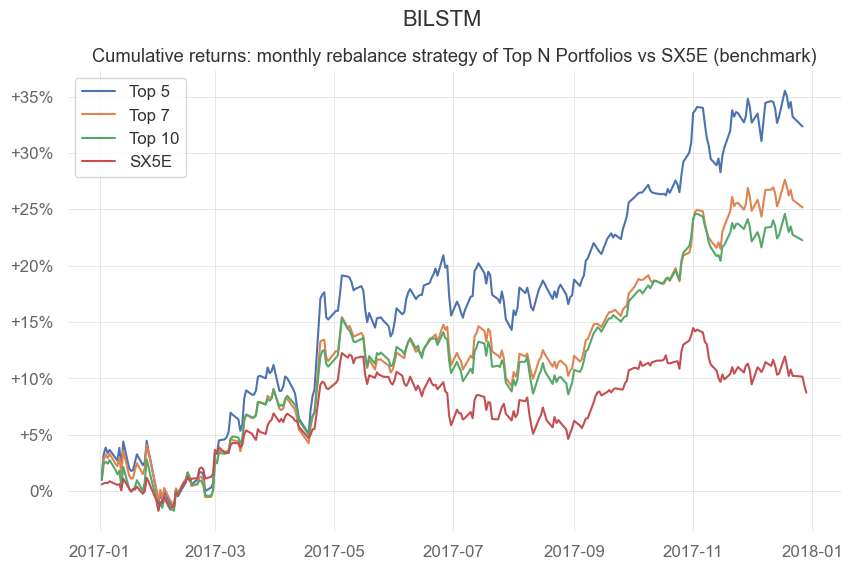

In [296]:
plt.plot(top5_cumret, label = 'Top 5')
plt.plot(top7_cumret, label = 'Top 7')
plt.plot(top10_cumret, label = 'Top 10')
plt.plot(benchmark_perf, label = 'SX5E')

ax = plt.gca()

# Define the percentage formatter function
def percentage_formatter(x, pos):
    if x == 0:
        return f'{int(x)}%'
    elif x > 0:
        return f'+{int(x)}%'
    else:
        return f'-{int(x)}%'
   
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('Cumulative returns: monthly rebalance strategy of Top N Portfolios vs SX5E (benchmark)')
plt.suptitle('BILSTM')

plt.legend();

In [297]:
qs.reports.metrics(top5_returns,
                benchmark = test_index_ret,
                title = 'LSTM: Top5 vs Benchmark',
                mode = "basic",
                prepare_returns = False)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2017-01-02   2017-01-02
End Period          2017-12-27   2017-12-27
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   9.5%         30.43%
CAGR﹪              6.58%        20.5%

Sharpe              0.96         1.81
Prob. Sharpe Ratio  83.83%       97.51%
Sortino             1.55         3.18
Sortino/√2          1.09         2.25
Omega               1.38         1.38

Max Drawdown        -6.79%       -5.67%
Longest DD Days     171          74

Gain/Pain Ratio     0.18         0.38
Gain/Pain (1M)      1.02         4.93

Payoff Ratio        1.1          1.18
Profit Factor       1.18         1.38
Common Sense Ratio  1.45         1.97
CPC Index           0.67         0.88
Tail Ratio          1.23         1.43
Outlier Win Ratio   3.87         2.51
Outlier Loss Ratio  3.94         2.77

MTD                 -0.53%       -1.32%
3M            

## CNN encoder - LSTM decoder

In [298]:
cnn_lstm = Sequential(name='CNN-LSTM')
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))

In [299]:
cnn_lstm.compile(loss='mse', optimizer='adam')

In [300]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
30/30 [==============================] - 2s 32ms/step - loss: 0.1121
Epoch 2/50
30/30 [==============================] - 1s 32ms/step - loss: 0.0230
Epoch 3/50
30/30 [==============================] - 1s 32ms/step - loss: 0.0129
Epoch 4/50
30/30 [==============================] - 1s 32ms/step - loss: 0.0116
Epoch 5/50
30/30 [==============================] - 1s 41ms/step - loss: 0.0085
Epoch 6/50
30/30 [==============================] - 1s 35ms/step - loss: 0.0074
Epoch 7/50
30/30 [==============================] - 1s 33ms/step - loss: 0.0060
Epoch 8/50
30/30 [==============================] - 1s 34ms/step - loss: 0.0057
Epoch 9/50
30/30 [==============================] - 1s 42ms/step - loss: 0.0049
Epoch 10/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0046
Epoch 11/50
30/30 [==============================] - 1s 43ms/step - loss: 0.0041
Epoch 12/50
30/30 [==============================] - 1s 37ms/step - loss: 0.0038
Epoch 13/50
30/30 [==================

In [304]:
top5_returns, top7_returns, top10_returns = monthly_rebalance_strategy(cnn_lstm, X_test, y_test, stocks_returns.loc['2017-01-02':], tukey.columns)

1/1 [==============================] - 0s 11ms/step


In [305]:
top5_cumret, top7_cumret, top10_cumret = ((1 + top5_returns).cumprod() - 1)*100, ((1 + top7_returns).cumprod() - 1)*100, ((1 + top10_returns).cumprod() - 1)*100

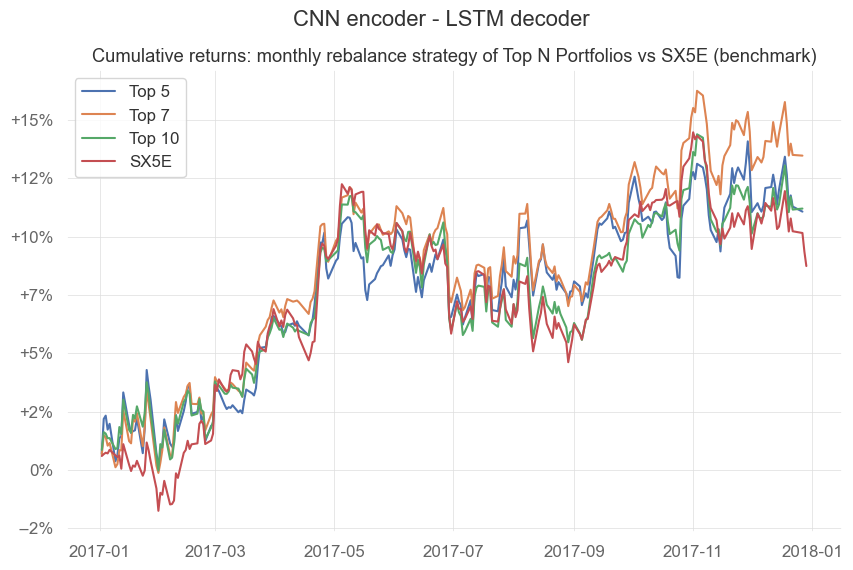

In [306]:
plt.plot(top5_cumret, label = 'Top 5')
plt.plot(top7_cumret, label = 'Top 7')
plt.plot(top10_cumret, label = 'Top 10')
plt.plot(benchmark_perf, label = 'SX5E')

ax = plt.gca()

# Define the percentage formatter function
def percentage_formatter(x, pos):
    if x == 0:
        return f'{int(x)}%'
    elif x > 0:
        return f'+{int(x)}%'
    else:
        return f'-{int(x)}%'
   
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('Cumulative returns: monthly rebalance strategy of Top N Portfolios vs SX5E (benchmark)')
plt.suptitle('CNN encoder - LSTM decoder')

plt.legend();

In [307]:
qs.reports.metrics(top7_returns,
                benchmark = test_index_ret,
                title = 'LSTM: Top5 vs Benchmark',
                mode = "basic",
                prepare_returns = False)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2017-01-02   2017-01-02
End Period          2017-12-27   2017-12-27
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   9.5%         12.71%
CAGR﹪              6.58%        8.76%

Sharpe              0.96         1.19
Prob. Sharpe Ratio  83.83%       88.23%
Sortino             1.55         1.76
Sortino/√2          1.09         1.25
Omega               1.22         1.22

Max Drawdown        -6.79%       -4.71%
Longest DD Days     171          142

Gain/Pain Ratio     0.18         0.22
Gain/Pain (1M)      1.02         2.28

Payoff Ratio        1.06         1.04
Profit Factor       1.18         1.22
Common Sense Ratio  1.45         1.23
CPC Index           0.64         0.71
Tail Ratio          1.23         1.01
Outlier Win Ratio   3.23         3.18
Outlier Loss Ratio  3.4          3.01

MTD                 -0.53%       -0.89%
3M           

## CNN-BILSTM

In [33]:
cnn_bilstm = Sequential(name = 'CNN-BiLSTM')

# Deep CNN encoder
cnn_bilstm.add(Conv1D(filters = 100, kernel_size = 3, input_shape=(LOOK_BACK, n_features)))
cnn_bilstm.add(BatchNormalization())
cnn_bilstm.add(ELU())
cnn_bilstm.add(Conv1D(filters = 100, kernel_size = 5))
cnn_bilstm.add(BatchNormalization())
cnn_bilstm.add(ELU())
cnn_bilstm.add(Conv1D(filters = 50, kernel_size = 7))
cnn_bilstm.add(BatchNormalization())
cnn_bilstm.add(ELU())
cnn_bilstm.add(MaxPooling1D(pool_size=2))

#
cnn_bilstm.add(Flatten())
cnn_bilstm.add(RepeatVector(FORECAST_RANGE))

# BiLSTM
cnn_bilstm.add(Bidirectional(LSTM(128, return_sequences=True)))     # sigmoid for gate state and tanh for state activations
cnn_bilstm.add(Dropout(0.2))
cnn_bilstm.add(Bidirectional(LSTM(64, return_sequences=True)))     # sigmoid for gate state and tanh for state activations
cnn_bilstm.add(Dropout(0.2))
cnn_bilstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_bilstm.add(TimeDistributed(Dense(n_features)))

In [309]:
cnn_bilstm.compile(optimizer='adam', loss='mse')

In [310]:
history = cnn_bilstm.fit(X_train, y_train, epochs=40, batch_size=32)

Epoch 1/40
30/30 [==============================] - 5s 47ms/step - loss: 0.0716
Epoch 2/40
30/30 [==============================] - 1s 46ms/step - loss: 0.0206
Epoch 3/40
30/30 [==============================] - 2s 49ms/step - loss: 0.0145
Epoch 4/40
30/30 [==============================] - 2s 57ms/step - loss: 0.0124
Epoch 5/40
30/30 [==============================] - 2s 52ms/step - loss: 0.0098
Epoch 6/40
30/30 [==============================] - 1s 47ms/step - loss: 0.0089
Epoch 7/40
30/30 [==============================] - 2s 58ms/step - loss: 0.0077
Epoch 8/40
30/30 [==============================] - 1s 46ms/step - loss: 0.0070
Epoch 9/40
30/30 [==============================] - 1s 48ms/step - loss: 0.0065
Epoch 10/40
30/30 [==============================] - 2s 53ms/step - loss: 0.0064
Epoch 11/40
30/30 [==============================] - 1s 46ms/step - loss: 0.0058
Epoch 12/40
30/30 [==============================] - 1s 46ms/step - loss: 0.0054
Epoch 13/40
30/30 [==================

In [311]:
top5_returns, top7_returns, top10_returns = monthly_rebalance_strategy(cnn_bilstm, X_test, y_test, stocks_returns.loc['2017-01-02':], tukey.columns, verbose=0)

In [313]:
top5_cumret, top7_cumret, top10_cumret = ((1 + top5_returns).cumprod() - 1)*100, ((1 + top7_returns).cumprod() - 1)*100, ((1 + top10_returns).cumprod() - 1)*100

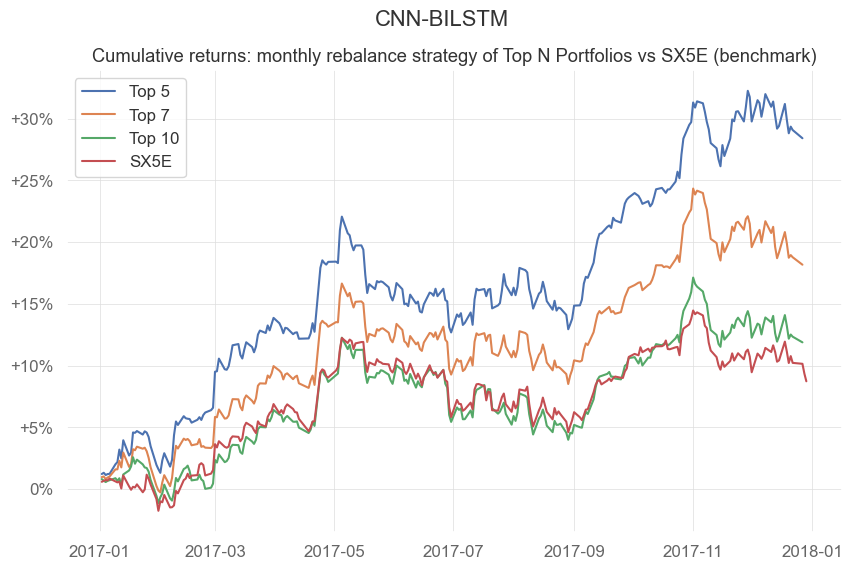

In [314]:
plt.plot(top5_cumret, label = 'Top 5')
plt.plot(top7_cumret, label = 'Top 7')
plt.plot(top10_cumret, label = 'Top 10')
plt.plot(benchmark_perf, label = 'SX5E')

ax = plt.gca()

# Define the percentage formatter function
def percentage_formatter(x, pos):
    if x == 0:
        return f'{int(x)}%'
    elif x > 0:
        return f'+{int(x)}%'
    else:
        return f'-{int(x)}%'
   
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('Cumulative returns: monthly rebalance strategy of Top N Portfolios vs SX5E (benchmark)')
plt.suptitle('CNN-BILSTM')

plt.legend();

## MonteCarlo Simulation

### Functions used for the MonteCarlo Simulation

In [23]:
def MC_portfolios_1month(model_initialized, n_sim, X_train, y_train, X_test, y_test, stocks_returns):

    cum_ret_list = []
    top5_ret_list = []
    top7_ret_list = []
    top10_ret_list = []

    for _ in range(n_sim):

        print(f'{_+1}/{n_sim} \n')

        model = model_initialized
        model.compile(optimizer='adam', loss='mse')
        
        ### FIT MODEL
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        top5_returns, top7_returns, top10_returns = monthly_rebalance_strategy(model, X_test, y_test, stocks_returns.loc['2017-01-02':], stocks_returns.columns, verbose=0)

        top5_cumret, top7_cumret, top10_cumret = ((1 + top5_returns).cumprod()), ((1 + top7_returns).cumprod()), ((1 + top10_returns).cumprod())

        cum_ret_list.append(top5_cumret) 
        cum_ret_list.append(top7_cumret)
        cum_ret_list.append(top10_cumret)
        top5_ret_list.append(top5_returns) 
        top7_ret_list.append(top7_returns) 
        top10_ret_list.append(top10_returns) 

        perf = {'Top 5 performance': (top5_cumret[-1] - 1)*100, 
                'Top 7 performance': (top7_cumret[-1] - 1)*100, 
                'Top 10 performance': (top10_cumret[-1] - 1)*100}

        print(perf)
    
    print('END OF THE SIMULATION')

    return cum_ret_list, top5_ret_list, top7_ret_list, top10_ret_list


def compare_MC_1month(benchmark_perf, test_index_returns, cumret_MC, top5_returns, top7_returns, top10_returns):
        
    top5_sharpe = np.round(np.mean([qs.stats.sharpe(series) for series in top5_returns]), 2)
    top5_md = np.round(np.mean([qs.stats.max_drawdown(series) for series in top5_returns]) * 100, 2)
    top5_avg_aret = np.round(np.mean([(((1 + np.mean(series)) ** 254) - 1) for series in top5_returns]) * 100, 2)
    top5_vol = np.round(np.mean([qs.stats.volatility(series) for series in top5_returns])  * 100, 2)

    top7_sharpe = np.round(np.mean([qs.stats.sharpe(series) for series in top7_returns]), 2)
    top7_md = np.round(np.mean([qs.stats.max_drawdown(series) for series in top7_returns]) * 100, 2)
    top7_avg_aret = np.round(np.mean([(((1 + np.mean(series)) ** 254) - 1) for series in top7_returns]) * 100, 2)
    top7_vol = np.round(np.mean([qs.stats.volatility(series)for series in top7_returns]) * 100, 2)

    top10_sharpe = np.round(np.mean([qs.stats.sharpe(series) for series in top10_returns]), 2)
    top10_md = np.round(np.mean([qs.stats.max_drawdown(series) for series in top10_returns]) * 100, 2)
    top10_avg_aret = np.round(np.mean([(((1 + np.mean(series)) ** 254) - 1) for series in top10_returns]) * 100, 2)
    top10_vol = np.round(np.mean([qs.stats.volatility(series) for series in top10_returns]) * 100, 2)

    print('Average metrics of best portfolio & worst portfolio vs SX5E metrics')

    display(pd.DataFrame(
        {'Sharpe ratio' : [qs.stats.sharpe(test_index_returns), top5_sharpe, top7_sharpe, top10_sharpe],
        'Max_drawdown' : [(qs.stats.max_drawdown(test_index_returns)*100), top5_md, top7_md, top10_md],
        'Annualized Return' : [(((1 + np.mean(test_index_returns)) ** 254) - 1) * 100, top5_avg_aret, top7_avg_aret, top10_avg_aret],
        'Annualized Vol' : [qs.stats.volatility(test_index_returns)*100, top5_vol, top7_vol, top10_vol]},
        index=['Benchmark', 'Top5', 'Top7', 'Top10']
    ).T)

    print('\n')
    count = 0
    for series in cumret_MC:
        if (series[-1] - 1)*100 < benchmark_perf[-1] :
            count += 1
    print('Number of portfolios that underperformed the index: ', count)

### Simple LSTM

In [28]:
cum_ret_list_LSTM, top5_retMC_LSTM,top7_retMC_LSTM, top10_retMC_LSTM = MC_portfolios_1month(model_enc_dec, 50, X_train, y_train, X_test, y_test, stocks_returns)

1/50 

{'Top 5 performance': 12.212147427532894, 'Top 7 performance': 9.404963032305202, 'Top 10 performance': 9.796689775451117}
2/50 

{'Top 5 performance': 13.054141805928277, 'Top 7 performance': 13.600315718407675, 'Top 10 performance': 11.904444800700386}
3/50 

{'Top 5 performance': 17.487728936079417, 'Top 7 performance': 14.863413554725092, 'Top 10 performance': 14.723308664383005}
4/50 

{'Top 5 performance': 15.583569797201967, 'Top 7 performance': 11.489246620886352, 'Top 10 performance': 10.581670091201655}
5/50 

{'Top 5 performance': 15.972762254305305, 'Top 7 performance': 15.286049286645675, 'Top 10 performance': 13.10480190047134}
6/50 

{'Top 5 performance': 16.31686877855025, 'Top 7 performance': 11.265909684204289, 'Top 10 performance': 6.484721998971255}
7/50 

{'Top 5 performance': 12.94902249723242, 'Top 7 performance': 13.483251530833629, 'Top 10 performance': 11.47528531879367}
8/50 

{'Top 5 performance': 15.735281968293325, 'Top 7 performance': 18.3131870763

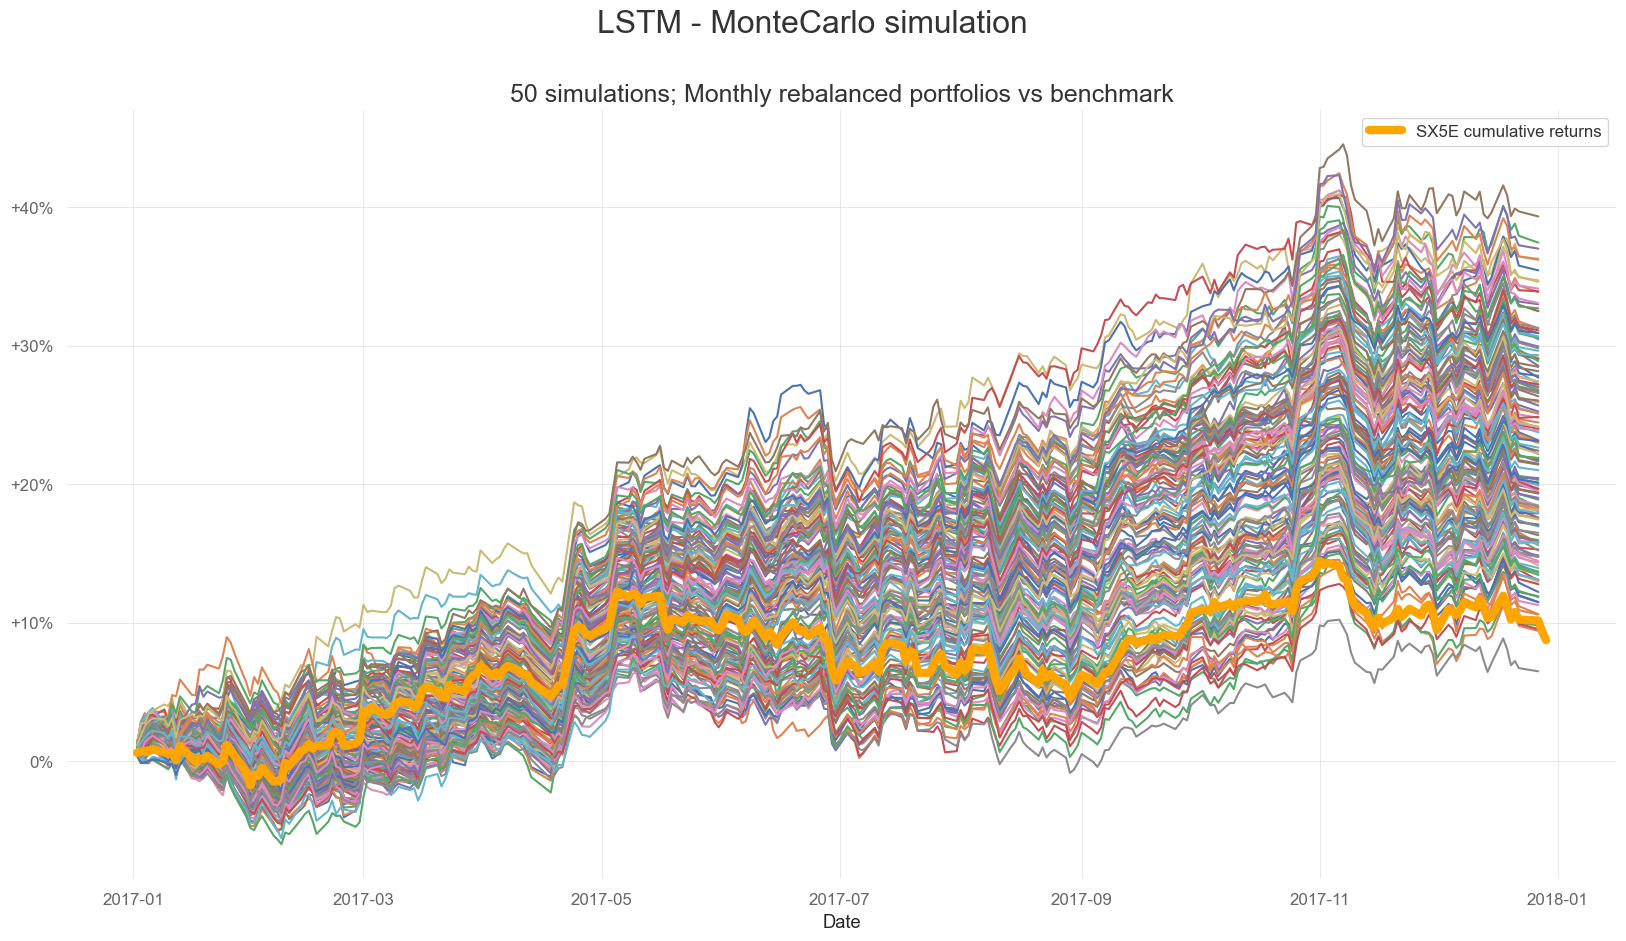

In [29]:
plt.figure(figsize=(20, 10))

for series in cum_ret_list_LSTM:
    plt.plot((series-1)*100)


plt.plot(benchmark_perf, linewidth=6, label=f'SX5E cumulative returns', color='orange')

ax = plt.gca()

# Define the percentage formatter function
def percentage_formatter(x, pos):
    if x == 0:
        return f'{int(x)}%'
    elif x > 0:
        return f'+{int(x)}%'
    else:
        return f'-{int(x)}%'
   
# Get the current axis
ax = plt.gca()
# Set the y-axis tick formatter to display percentage
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.xlabel('Date')
plt.title('50 simulations; Monthly rebalanced portfolios vs benchmark', fontsize=18)
plt.suptitle('LSTM - MonteCarlo simulation ', fontsize=23)
plt.legend()
plt.grid(True)
plt.show()

In [30]:
"""file_path = ['data/saved_MC/cum_ret_list_LSTM.pkl', 'data/saved_MC/top5_retMC_LSTM.pkl', 'data/saved_MC/top7_retMC_LSTM.pkl', 'data/saved_MC/top10_retMC_LSTM.pkl']

with open(file_path[0], 'rb') as file:
    cum_ret_list_LSTM = pickle.load(file)
with open(file_path[1], 'rb') as file:
    top5_retMC_LSTM = pickle.load(file)
with open(file_path[2], 'rb') as file:
    top7_retMC_LSTM = pickle.load(file)
with open(file_path[3], 'rb') as file:
    top10_retMC_LSTM = pickle.load(file)"""

"file_path = ['data/saved_MC/cum_ret_list_LSTM.pkl', 'data/saved_MC/top5_retMC_LSTM.pkl', 'data/saved_MC/top7_retMC_LSTM.pkl', 'data/saved_MC/top10_retMC_LSTM.pkl']\n\nwith open(file_path[0], 'rb') as file:\n    cum_ret_list_LSTM = pickle.load(file)\nwith open(file_path[1], 'rb') as file:\n    top5_retMC_LSTM = pickle.load(file)\nwith open(file_path[2], 'rb') as file:\n    top7_retMC_LSTM = pickle.load(file)\nwith open(file_path[3], 'rb') as file:\n    top10_retMC_LSTM = pickle.load(file)"

In [31]:
compare_MC_1month(benchmark_perf, test_index_ret, cum_ret_list_LSTM, top5_retMC_LSTM, top7_retMC_LSTM, top10_retMC_LSTM)

Average metrics of best portfolio & worst portfolio vs SX5E metrics


,Benchmark,Top5,Top7,Top10
Sharpe ratio,0.885662,1.68,1.71,1.69
Max_drawdown,-6.794479,-6.11,-5.60,-5.07
Annualized Return,9.275149,24.43,23.37,21.68
Annualized Vol,9.937853,12.86,12.11,11.49




Number of portfolios that underperformed the index:  1


### CNN-BILSTM

In [34]:
cum_ret_list_CNN_LSTM, top5_retMC_CNN_LSTM,top7_retMC_CNN_LSTM, top10_retMC_CNN_LSTM = MC_portfolios_1month(cnn_bilstm, 30, X_train, y_train, X_test, y_test, stocks_returns)


1/30 

{'Top 5 performance': 11.071595672662692, 'Top 7 performance': 12.601156524309909, 'Top 10 performance': 13.131710731359725}
2/30 

{'Top 5 performance': 20.090953901661223, 'Top 7 performance': 16.926507678566516, 'Top 10 performance': 11.569535251565766}
3/30 

{'Top 5 performance': 22.90264492861791, 'Top 7 performance': 17.482487381209477, 'Top 10 performance': 12.43853358515221}
4/30 

{'Top 5 performance': -4.143574083711055, 'Top 7 performance': -1.677872618448828, 'Top 10 performance': 3.6960523117094857}
5/30 

{'Top 5 performance': 16.326018524153053, 'Top 7 performance': 15.478068008036573, 'Top 10 performance': 15.834512290393388}
6/30 

{'Top 5 performance': 4.900805461986946, 'Top 7 performance': 10.242610898397796, 'Top 10 performance': 11.156439203308866}
7/30 

{'Top 5 performance': 11.523701028082222, 'Top 7 performance': 13.97237911817053, 'Top 10 performance': 11.693705258693887}
8/30 

{'Top 5 performance': -2.5244742652550167, 'Top 7 performance': -0.469706

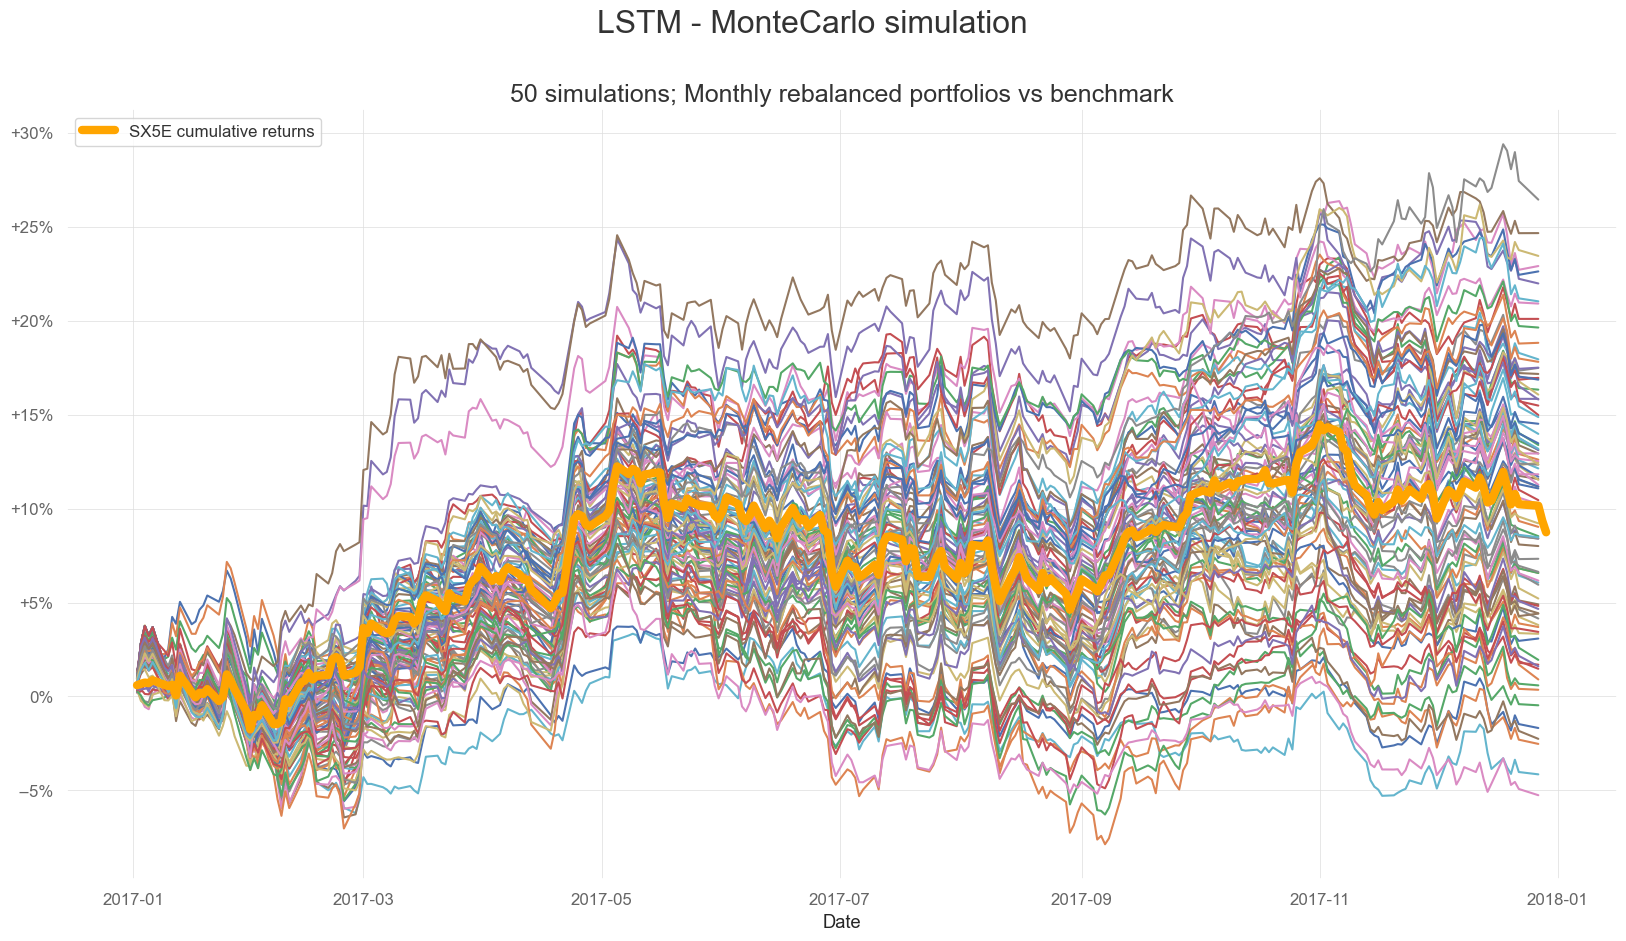

In [35]:
plt.figure(figsize=(20, 10))

for series in cum_ret_list_CNN_LSTM:
    plt.plot((series-1)*100)


plt.plot(benchmark_perf, linewidth=6, label=f'SX5E cumulative returns', color='orange')

ax = plt.gca()

# Define the percentage formatter function
def percentage_formatter(x, pos):
    if x == 0:
        return f'{int(x)}%'
    elif x > 0:
        return f'+{int(x)}%'
    else:
        return f'-{int(x)}%'
   
# Get the current axis
ax = plt.gca()
# Set the y-axis tick formatter to display percentage
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.xlabel('Date')
plt.title('50 simulations; Monthly rebalanced portfolios vs benchmark', fontsize=18)
plt.suptitle('LSTM - MonteCarlo simulation ', fontsize=23)
plt.legend()
plt.grid(True)
plt.show()

In [36]:
"""file_path = ['data/saved_MC/cum_ret_list_CNN_LSTM.pkl', 'data/saved_MC/top5_retMC_CNN_LSTM.pkl', 'data/saved_MC/top7_retMC_CNN_LSTM.pkl', 'data/saved_MC/top10_retMC_CNN_LSTM.pkl']

with open(file_path[0], 'rb') as file:
    cum_ret_list_CNN_LSTM = pickle.load(file)
with open(file_path[1], 'rb') as file:
    top5_retMC_CNN_LSTM = pickle.load(file)
with open(file_path[2], 'rb') as file:
    top7_retMC_CNN_LSTM = pickle.load(file)
with open(file_path[3], 'rb') as file:
    top10_retMC_CNN_LSTM = pickle.load(file)"""

"file_path = ['data/saved_MC/cum_ret_list_CNN_LSTM.pkl', 'data/saved_MC/top5_retMC_CNN_LSTM.pkl', 'data/saved_MC/top7_retMC_CNN_LSTM.pkl', 'data/saved_MC/top10_retMC_CNN_LSTM.pkl']\n\nwith open(file_path[0], 'rb') as file:\n    cum_ret_list_CNN_LSTM = pickle.load(file)\nwith open(file_path[1], 'rb') as file:\n    top5_retMC_CNN_LSTM = pickle.load(file)\nwith open(file_path[2], 'rb') as file:\n    top7_retMC_CNN_LSTM = pickle.load(file)\nwith open(file_path[3], 'rb') as file:\n    top10_retMC_CNN_LSTM = pickle.load(file)"

In [37]:
compare_MC_1month(benchmark_perf, test_index_ret, cum_ret_list_CNN_LSTM, top5_retMC_CNN_LSTM,top7_retMC_CNN_LSTM, top10_retMC_CNN_LSTM)

Average metrics of best portfolio & worst portfolio vs SX5E metrics


,Benchmark,Top5,Top7,Top10
Sharpe ratio,0.885662,0.85,0.84,0.83
Max_drawdown,-6.794479,-8.43,-7.65,-7.17
Annualized Return,9.275149,12.39,11.47,10.64
Annualized Vol,9.937853,13.54,12.72,11.99




Number of portfolios that underperformed the index:  37


### Save MC variables to speed up the process

In [38]:
file_path = ['data/saved_MC/cum_ret_list_LSTM.pkl', 'data/saved_MC/top5_retMC_LSTM.pkl',  'data/saved_MC/top7_retMC_LSTM.pkl', 'data/saved_MC/top10_retMC_LSTM.pkl']
with open(file_path[0], 'wb') as file:
    # Dump the list into the file
    pickle.dump(cum_ret_list_LSTM, file)
with open(file_path[1], 'wb') as file:
    # Dump the list into the file
    pickle.dump(top5_retMC_LSTM, file)
with open(file_path[2], 'wb') as file:
    # Dump the list into the file
    pickle.dump(top7_retMC_LSTM, file)
with open(file_path[3], 'wb') as file:
    # Dump the list into the file
    pickle.dump(top10_retMC_LSTM, file)

In [39]:
file_path = ['data/saved_MC/cum_ret_list_CNN_LSTM.pkl', 'data/saved_MC/top5_retMC_CNN_LSTM.pkl',  'data/saved_MC/top7_retMC_CNN_LSTM.pkl', 'data/saved_MC/top10_retMC_CNN_LSTM.pkl']
with open(file_path[0], 'wb') as file:
    # Dump the list into the file
    pickle.dump(cum_ret_list_CNN_LSTM, file)
with open(file_path[1], 'wb') as file:
    # Dump the list into the file
    pickle.dump(top5_retMC_CNN_LSTM, file)
with open(file_path[2], 'wb') as file:
    # Dump the list into the file
    pickle.dump(top7_retMC_CNN_LSTM, file)
with open(file_path[3], 'wb') as file:
    # Dump the list into the file
    pickle.dump(top10_retMC_CNN_LSTM, file)